In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2


In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi','dset']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'reverse spiral', 'pinwheel', 'forward spiral']

# Predict synthetic data based on the model parameters

```python
stim_info='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description.csv'
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info)

ecc_range = (0, 12)
n_ecc = 121
angle_range = (np.deg2rad(0), np.deg2rad(360))
n_angle = 360
ecc_col = 'eccentricity'
angle_col = 'angle'
synthetic_df = vis2D.make_synthetic_dataframe_for_2D(stim_info,
                                                ecc_range, n_ecc,
                                                angle_range, n_angle,
                                                ecc_col, angle_col)

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['Pv'] = synthetic_df.apply(model.get_Pv_row, 
                                        params=final_params.query('sub == "subj01" & vroinames == "V1"'), 
                                        axis=1)



# Load model parameters

In [3]:
pt_file_list = []
dset='nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, ['V1', 'V2', 'V3']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', dset,
                             f'model-params_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])


In [4]:
pt_file_list = []
dset = 'broderick'
tfunc_types=['corrected']
for subj, roi, tfunc in itertools.product(broderick_subj_list, ['V1'], tfunc_types):
    file_name = os.path.join(results_dir, dset, f'tfunc-{tfunc}_model_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [5]:
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')

final_params = pd.concat((broderick_df, nsd_df), axis=0)

# Load synthetic data

In [6]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
dset='nsdsyn'
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1', 'V2', 'V3'], ['relative','absolute']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', dset,
                             f'prediction_frame-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_dset-{dset}_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['frame'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [7]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
dset='broderick'
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['relative','absolute']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', dset,
                             f'tfunc-corrected_prediction_frame-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_dset-{dset}_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D)

broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [17]:
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

# Plot each parameter and prediction

## Bandwidth and predicted tuning curves

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Spatial frequency (cpd)', ylabel='Predicted\nBOLD Response'>],
       dtype=object))

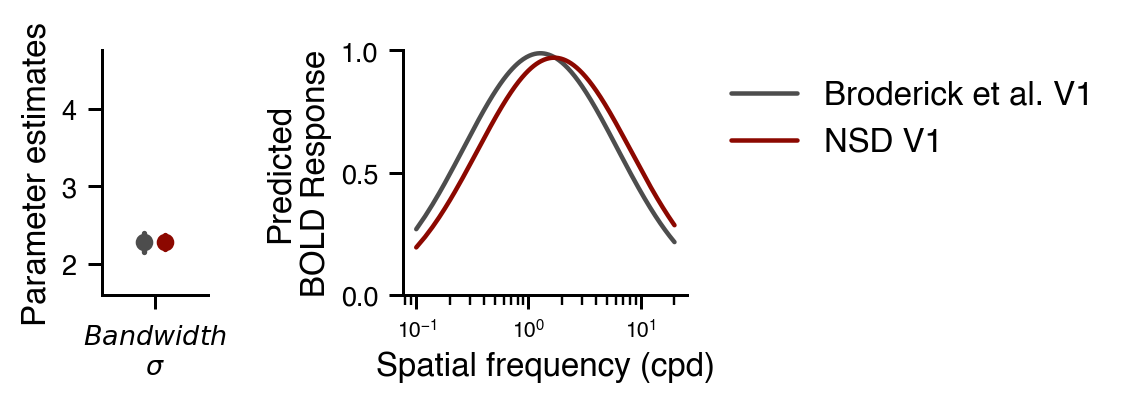

In [13]:
local_ori = np.deg2rad(90)
ecc = 5
angle = np.deg2rad(180)

tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
weighted_mean_df = vis2D.get_weighted_average_of_params(tmp, ['dset_type'], ecc, angle, local_ori)

vis2D.plot_param_and_prediction(params_df=tmp, params=['sigma'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=weighted_mean_df, prediction_y=None,
                                pal=pal,
                                params_ylim=(1.6, 4.75), params_yticks=[2, 3, 4],
                                prediction_ylim=None, prediction_yticks=None,
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(3.5, 1.5), width_ratios=[1.5, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all', 'param-bandwidth_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Spatial frequency (cpd)', ylabel='Predicted\nBOLD Response'>],
       dtype=object))

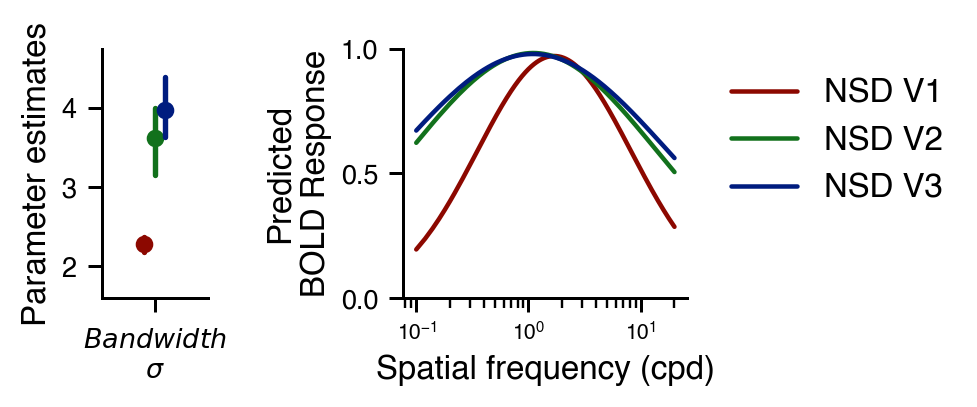

In [42]:
local_ori = np.deg2rad(90)
ecc = 5
angle = np.deg2rad(180)

tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
weighted_mean_df = vis2D.get_weighted_average_of_params(tmp, ['dset_type'], ecc, angle, local_ori)

vis2D.plot_param_and_prediction(params_df=tmp, params=['sigma'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=weighted_mean_df, prediction_y=None,
                                pal=pal,
                                params_ylim=(1.6, 4.75), params_yticks=[2, 3, 4],
                                prediction_ylim=None, prediction_yticks=None,
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(3.5, 1.5), width_ratios=[1.5, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all', 'param-bandwidth_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))


## slope and intercept

(<Figure size 972x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity', ylabel='Preferred period (deg)'>],
       dtype=object))

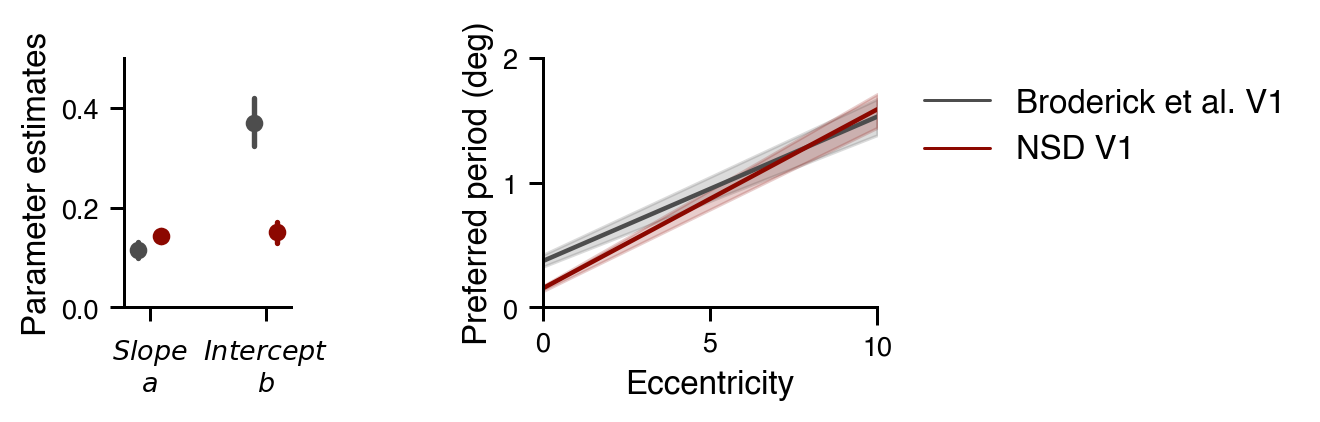

In [41]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')

ecc_list=[0,10]
ecc_df = ecc_df.query('frame == "relative" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

vis2D.plot_param_and_prediction(params_df=tmp, params=['slope','intercept'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=ecc_df, prediction_y='Pv',
                                pal=pal,
                                params_ylim=(0, 0.5), params_yticks=[0, 0.2, 0.4],
                                prediction_ylim=(0,2), prediction_yticks=[0,1,2],
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(4.5, 1.5), width_ratios=[1,2], 
                                save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all', 'param-ecceffect_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))



(<Figure size 972x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity', ylabel='Preferred period (deg)'>],
       dtype=object))

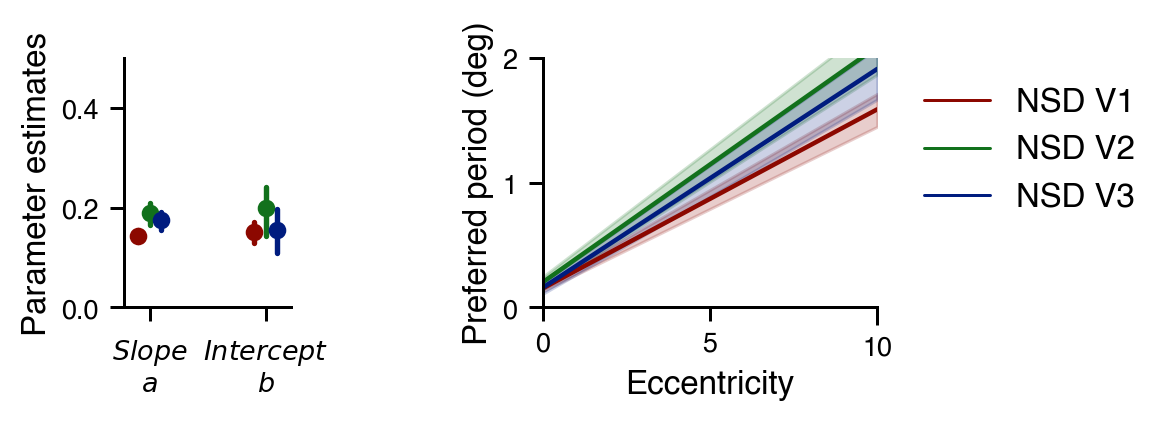

In [43]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')

ecc_list=[0,10]
ecc_df = ecc_df.query('frame == "relative" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

vis2D.plot_param_and_prediction(params_df=tmp, params=['slope','intercept'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=ecc_df, prediction_y='Pv',
                                pal=pal,
                                params_ylim=(0, 0.5), params_yticks=[0, 0.2, 0.4],
                                prediction_ylim=(0,2), prediction_yticks=[0,1,2],
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(4.5, 1.5), width_ratios=[1,2], 
                                save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all', 'param-ecceffect_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))

# Plot preferred period for each parameter

## P1: Horizontal gratings vs. vertical gratings

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(vertical — horizontal)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

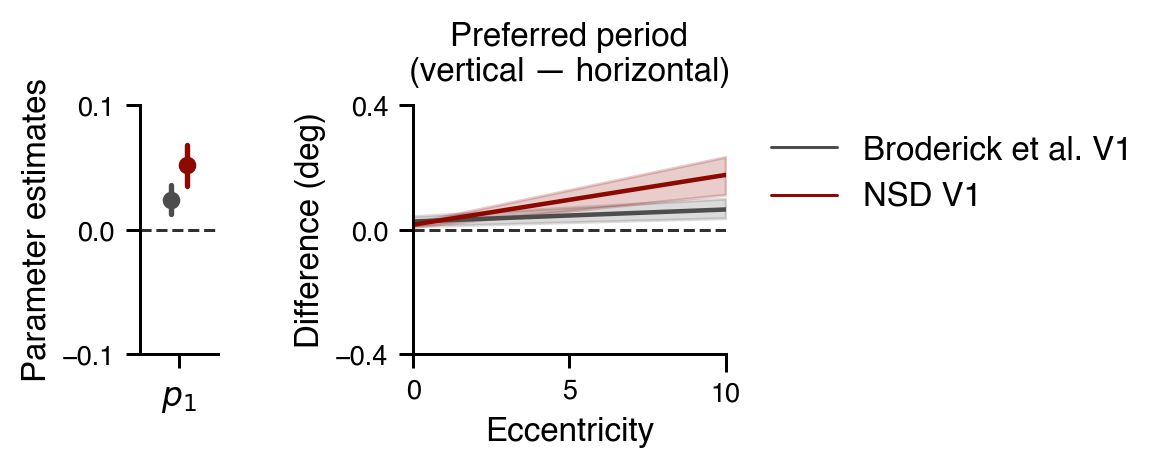

In [44]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'vertical', 'horizontal', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_1'], 
                          params_ylim=(-0.1, 0.1), params_yticks= [-0.1,0,0.1], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.4, 0.4), prediction_yticks= [-0.4,0,0.4], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(vertical — horizontal)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p1_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(vertical — horizontal)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

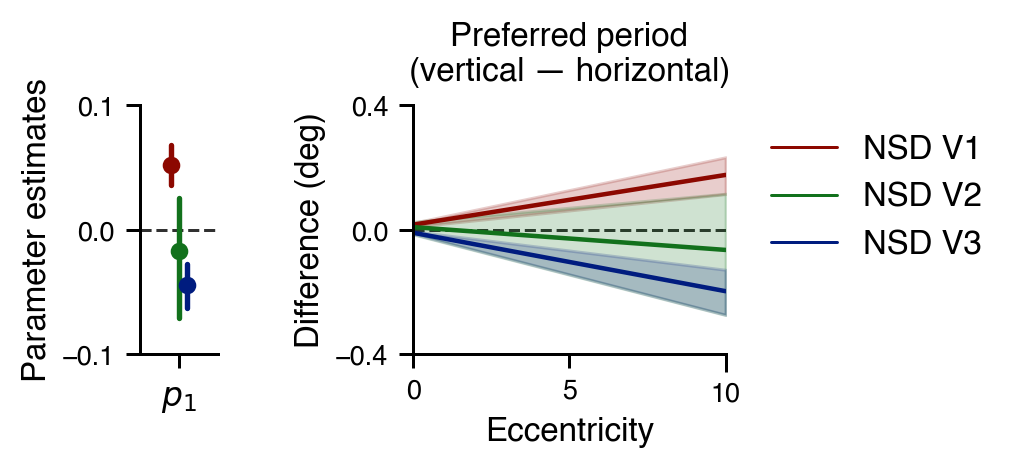

In [45]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'vertical', 'horizontal', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_1'], 
                          params_ylim=(-0.1, 0.1), params_yticks= [-0.1,0,0.1], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.4, 0.4), prediction_yticks= [-0.4,0,0.4], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(vertical — horizontal)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p1_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))


## P2: cardinal vs. oblique

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(cardinal — oblique)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

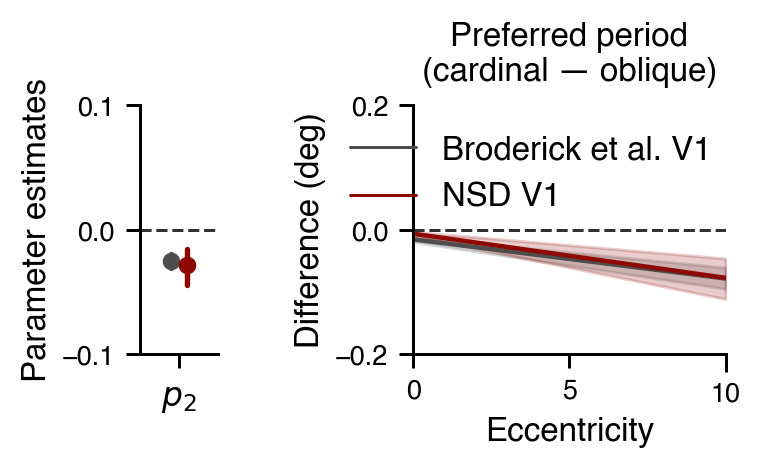

In [46]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'cardinal', 'oblique', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_2'], 
                          params_ylim=(-0.1, 0.1), params_yticks= [-0.1,0,0.1], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.2, 0.2), prediction_yticks= [-0.2,0,0.2], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(cardinal — oblique)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p2_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(cardinal — oblique)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

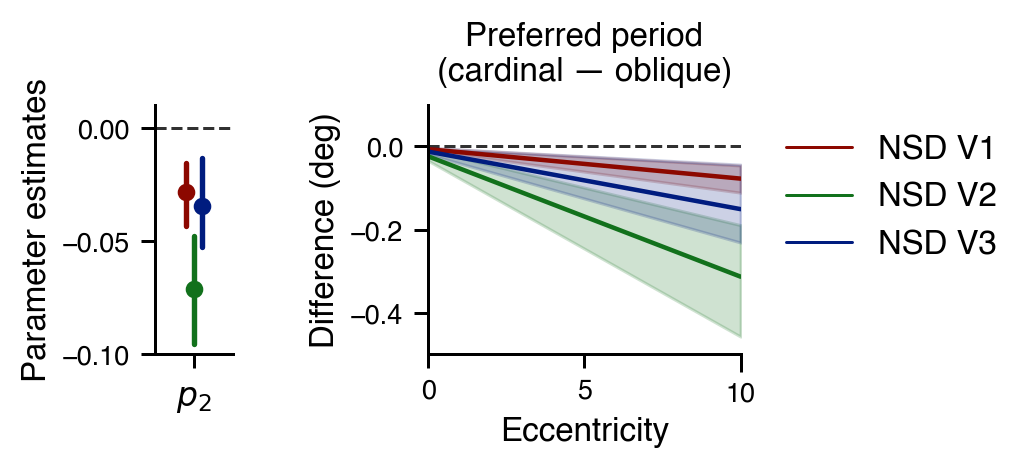

In [47]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'cardinal', 'oblique', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_2'], 
                          params_ylim=(-0.1, 0.01), params_yticks= [-0.1,-0.05,0], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.1), prediction_yticks= [-0.4,-0.2,0], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(cardinal — oblique)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p2_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))



## P3: Annulus vs. pinwheel

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(annulus — pinwheel)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

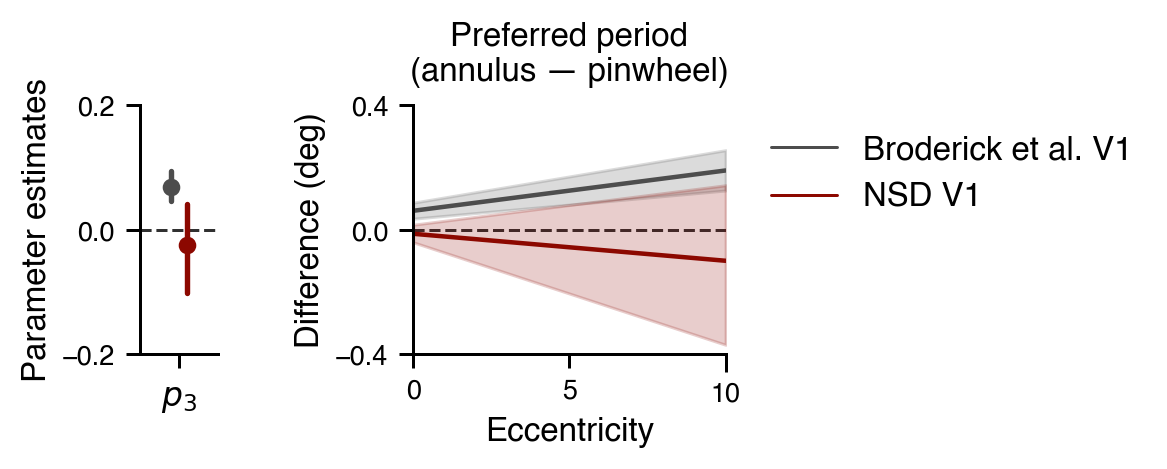

In [48]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'annulus', 'pinwheel', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_3'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.4, 0.4), prediction_yticks= [-0.4,0,0.4], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(annulus — pinwheel)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p3_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(annulus — pinwheel)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

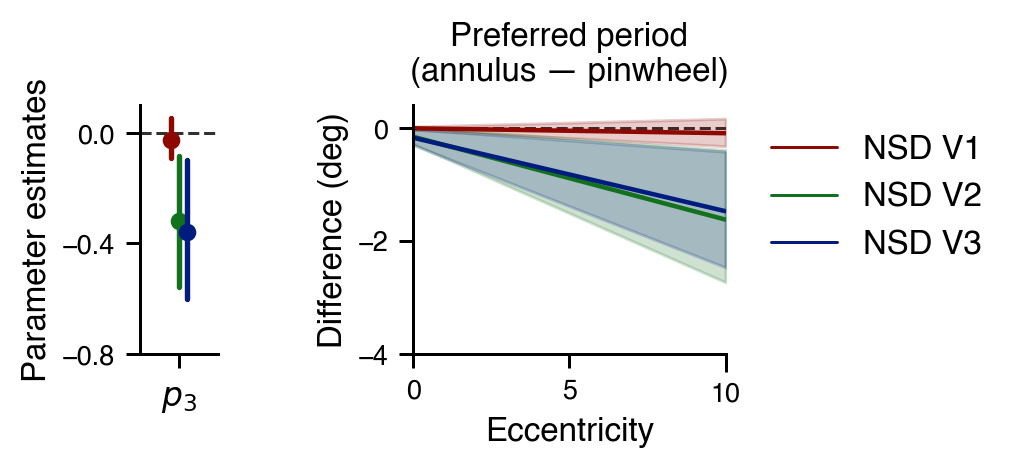

In [49]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'annulus', 'pinwheel', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_3'], 
                          params_ylim=(-0.8, 0.1), params_yticks= [-0.8,-0.4,0], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-4, 0.4), prediction_yticks= [-4,-2,0], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(annulus — pinwheel)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p3_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))

## P4: Spirals vs. annulus/pinwheel

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(non-spirals — spirals)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

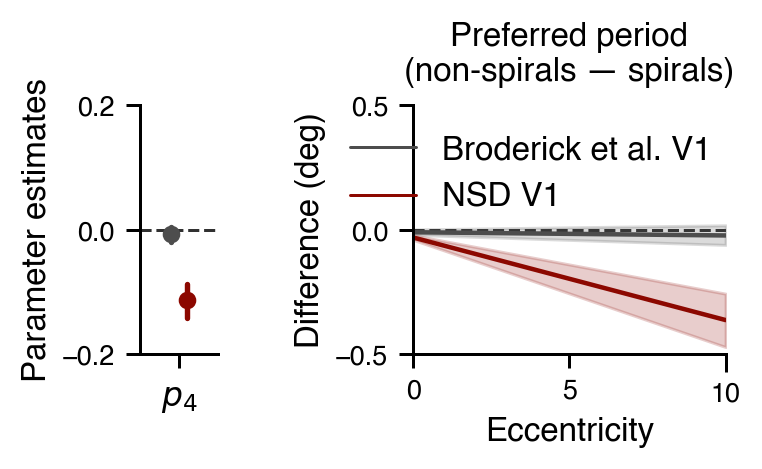

In [50]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'non-spirals', 'spirals', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_4'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(non-spirals — spirals)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p4_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

(<Figure size 756x324 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:title={'center':'Preferred period\n(non-spirals — spirals)'}, xlabel='Eccentricity', ylabel='Difference (deg)'>],
       dtype=object))

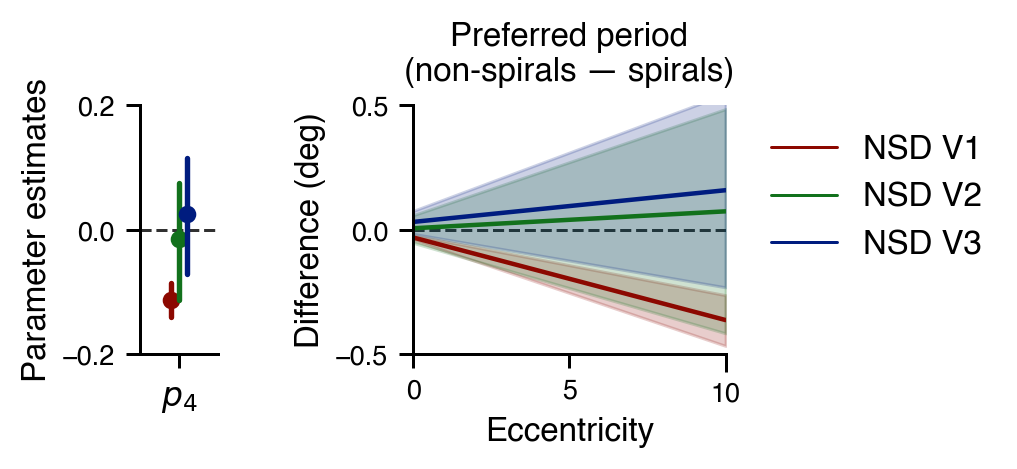

In [51]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'non-spirals', 'spirals', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_4'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(non-spirals — spirals)',
                          figsize=(3.5, 1.5), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p4_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))

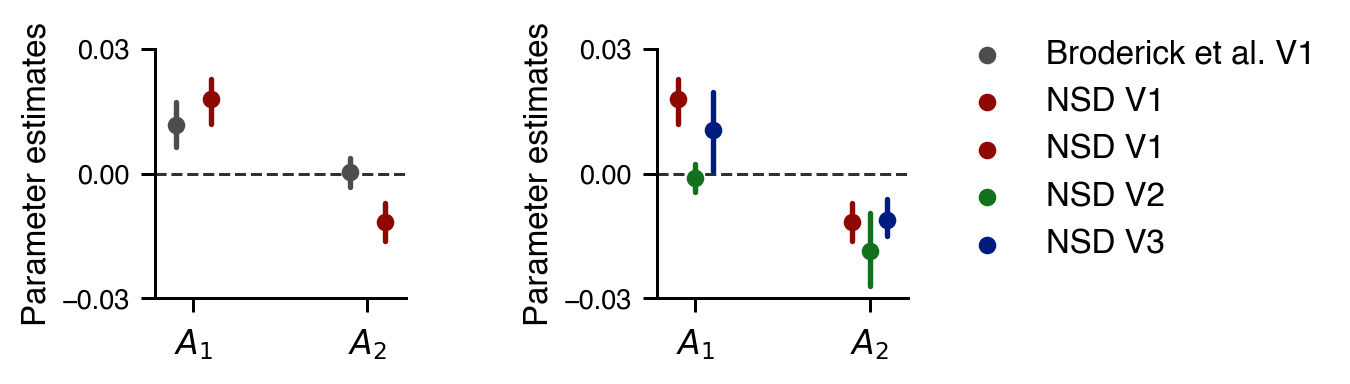

In [63]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
tmp2, hue_order2, pal2 = vis2D.filter_for_goal(final_params, 'extension')


fig, axes = plt.subplots(1, 2, figsize=(4.5,1.5),
                         gridspec_kw={'width_ratios': (2,2)},
                         sharey=False, sharex=False)

g = vis2D.plot_precision_weighted_avg_parameter(tmp, ['A_1', 'A_2'], 'dset_type', hue_order, ax=axes[0], ylim=(-0.03,0.03), yticks=[-0.03,0,0.03], pal=pal)
g.legend_.remove()
g.margins(x=0.1)

g = vis2D.plot_precision_weighted_avg_parameter(tmp2, ['A_1', 'A_2'], 'dset_type', hue_order2, ax=axes[1], ylim=(-0.03,0.03), yticks=[-0.03,0,0.03], pal=pal2)
g.margins(x=0.1)
g.legend_.remove()
#g.legend(bbox_to_anchor=(1.05, 1), loc='best', frameon=False)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, frameon=False, loc='upper right', bbox_to_anchor=(1.35, 1))
fig.subplots_adjust(wspace=1)

utils.save_fig(os.path.join(fig_dir, 'sfp_model', 'results_2D', 'all','param-p4_goal-both_lr-0.0005_eph-30000_vs-pRFsize.svg'))